**Desarrollo del enigma**

El presente reto aborda aspectos muy relevantes:

- Vectorización,
- Procesamiento de títulos similares
- Análisis de complejidad algorítmica

En él evaluaremos cómo se comportan ambos enfoques tanto con conjuntos de datos de pequeño tamaño como con volúmenes crecientes. En concreto:

El método de matriz completa requiere comparar cada par de documentos, por lo que su complejidad es O(n²).

El algoritmo KNN, en cambio, aprovecha estructuras de búsqueda para localizar sólo los k vecinos más cercanos, lo que le confiere una complejidad aproximada de O(k·n·log n).

Este estudio nos permitirá escoger la estrategia más adecuada según nuestras prioridades de rendimiento y precisión. Sobretodo porque estamos corriendo en una máquina local y puede "colgarse" el modelado si no se seleciona el apropiado

In [1]:
import sys
import os
import importlib
import warnings
warnings.filterwarnings('ignore')
print(f" ><>< Directorio actual: {os.getcwd()}  ><>< ")
def get_environment_name():
    if 'CONDA_DEFAULT_ENV' in os.environ:
        return os.environ['CONDA_DEFAULT_ENV']
    elif 'VIRTUAL_ENV' in os.environ:
        return os.path.basename(os.environ['VIRTUAL_ENV'])
    elif 'conda' in sys.executable.lower():
        path_parts = sys.executable.split(os.sep)
        if 'envs' in path_parts:
            env_index = path_parts.index('envs')
            if env_index + 1 < len(path_parts):
                return path_parts[env_index + 1]
        return 'base'
    else:
        return 'sistema (sin entorno virtual)'
env_name = get_environment_name()
print(f" ><>< Nombre del entorno: {env_name} ><><><")
packages_to_check = [
    'pandas',
    'numpy', 
    'matplotlib',
    'seaborn',
    'plotly',
    'sklearn',
    'boto3',
    'jupyter',
    'ipykernel',
    'unidecode'
]

installed_packages = {}
missing_packages = []

for package_name in packages_to_check:
        if package_name == 'sklearn':
            import sklearn as pkg
        else:
            pkg = importlib.import_module(package_name)
        
        version = getattr(pkg, '__version__', 'ok')
        installed_packages[package_name] = version
        print(f" {package_name:12} v{version}")
import pandas as pd
import numpy as np
import boto3
from io import StringIO
import unicodedata
import re
import time
from typing import Tuple, List
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from typing import Dict, List, Tuple, Optional
import warnings
import random
from itertools import combinations
warnings.filterwarnings('ignore')
print("Etapa Verificación de bibliotecas en Kernel : ✓")

 ><>< Directorio actual: C:\Users\usuario\Desktop\DS  ><>< 
 ><>< Nombre del entorno: ml_permanente ><><><
 pandas       v2.2.3
 numpy        v1.26.4
 matplotlib   v3.10.0
 seaborn      v0.13.2
 plotly       v6.2.0
 sklearn      v1.6.1
 boto3        v1.39.9
 jupyter      vok
 ipykernel    v6.29.5
 unidecode    vok
Etapa Verificación de bibliotecas en Kernel : ✓


In [2]:
cred_df = pd.read_csv(r"C:\Users\usuario\Downloads\sanmi_accessKeys.csv")
aws_access_key_id     = cred_df.loc[0, 'Access key ID']
aws_secret_access_key = cred_df.loc[0, 'Secret access key']

In [3]:
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name='us-east-2'
)

In [4]:
BUCKET_NAME  = "aws-sam-cli-managed-default-samclisourcebucket-ko8qnsdeyujb"
OBJECT_KEY1  = "elbaldedejuan/DS_MeLi/items_titles.csv"
OBJECT_KEY2  = "elbaldedejuan/DS_MeLi/items_titles_test.csv"
# Cliente S3 (usa credenciales configuradas en ~/.aws o variables de entorno)
s3 = boto3.client("s3")
def read_s3_csv(bucket: str, key: str) -> pd.DataFrame:
    """Descarga un CSV pequeño/mediano desde S3 y lo lee en un DataFrame."""
    obj = s3.get_object(Bucket=bucket, Key=key)
    csv_content = obj["Body"].read().decode("utf-8")
    return pd.read_csv(StringIO(csv_content))
df      = read_s3_csv(BUCKET_NAME, OBJECT_KEY1)   
df_test = read_s3_csv(BUCKET_NAME, OBJECT_KEY2)   
print("Conexión con datos en nube : ✓")

Conexión con datos en nube : ✓


Este fragmento define las columnas clave (ID_COL y TEXT_COL) y crea una clase PreprocesadorTexto cuyos métodos permiten normalizar cadenas (eliminar acentos, pasar a minúsculas y limpiar espacios) y preparar dos DataFrames (restablecer índices, detectar duplicados y aplicar la normalización).

In [5]:
# Nombre de la columna que almacenará el índice tras reset_index()
ID_COL    = "item_idx"         
# Nombre de la columna que contiene el título de cada ítem
TEXT_COL  = "ITE_ITEM_TITLE"       
class PreprocesadorTexto:
    def __init__(self):
        # Constructor vacío
        pass    
    def normalizadordetexto(self, txt: str) -> str:
        if pd.isna(txt):
            return "" 
        txt = (
            unicodedata.normalize("NFKD", str(txt))
            .encode("ascii", "ignore")
            .decode("ascii")
            .lower()
        )
        txt = re.sub(r"\s+", " ", txt).strip()
        return txt    
    def preparadorData(
        self,
        df_train: pd.DataFrame,
        df_test:  pd.DataFrame
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        df_train = df_train.reset_index().rename(columns={"index": ID_COL})
        df_test  = df_test.reset_index().rename(columns={"index": ID_COL})       
        # Contar duplicados en el texto
        dups_train = df_train.duplicated(subset=[TEXT_COL]).sum()
        dups_test  = df_test.duplicated(subset=[TEXT_COL]).sum()        
        # Mostrar mensaje según existan duplicados o no
        print(
            f"Duplicados en catálogo: {dups_train}"
            if dups_train else "No se hallan duplicados en catálogo C:"
        )
        print(
            f"Duplicados en test: {dups_test}"
            if dups_test else "No se hallan duplicados en test C:"
        )        
        # Normalizar texto rellenando primero posibles NaN
        df_train[TEXT_COL] = (
            df_train[TEXT_COL]
            .fillna("")                      
            .apply(self.normalizadordetexto)
        )
        df_test[TEXT_COL] = (
            df_test[TEXT_COL]
            .fillna("")                      
            .apply(self.normalizadordetexto)
        )        
        return df_train, df_test

Este bloque define la clase VectorizadorTexto, que construye un vectorizador TF-IDF combinando dos esquemas de tokenización (por palabras y por caracteres) con parámetros de n-gramas, frecuencia mínima y límite de características, y devuelve el objeto FeatureUnion resultante.

In [6]:
class VectorizadorTexto:
    def __init__(self):
        # Atributo donde se almacenará el transformador combinado
        self.vectorizer = None    
    def preparadorVectores(self):
        vect_word = TfidfVectorizer(
            analyzer="word",        # Tokeniza por palabras
            ngram_range=(1, 2),     # unigramas y bigramas
            min_df=2,               # ignora términos en menos de 2 documentos
            sublinear_tf=True,      # usa 1 + log(tf) en lugar de tf
            max_features=10000      # limita a las 10 000 características más frecuentes
        )                
        vect_char = TfidfVectorizer(
            analyzer="char_wb",     # tokeniza por secuencias de caracteres dentro de palabras
            ngram_range=(3, 5),     # secuencias de 3 a 5 caracteres
            min_df=2,               # ignora secuencias en menos de 2 documentos
            sublinear_tf=True,      # TF sublineal
            max_features=10000      # límite de 10 000 características
        )         
        # Combina ambos vectorizadores en uno solo
        self.vectorizer = FeatureUnion([
            ("word", vect_word),
            ("char", vect_char)
        ])
        return self.vectorizer

La clase CalculadorSimilitudes permite extraer pares de títulos con similitud de coseno por encima de un umbral definido, ofreciendo dos métodos: uno que calcula la matriz completa de similitudes y otro que usa un enfoque basado en KNN, además de registrar los tiempos de ejecución de cada método

Planeo que el preparador de parejas transforme los títulos con el vectorizer., Calcula la matriz completa de similitud de coseno, Recorre solo la mitad superior de la matriz para evitar duplicados, Guarda pares con score ≥ similarity_threshold, Mide y registra el tiempo de ejecución bajo el método "Matrix Method", Devuelve un DataFrame con columnas: **'ITE_ITEM_TITLE1', 'ITE_ITEM_TITLE2', 'similarity'**

Planeo también un preparador KNN que transforma los títulos con el vectorizer, ajusta un modelo NearestNeighbors (cosine) a X_test,para cada ítem obtiene los k+1 vecinos (incluye el mismo), Convierte distancia a similitud (1 - distancia) y filtra:

          • i != j para evitar el mismo ítem.
          • j > i para no duplicar el par.
          • similitud ≥ similarity_threshold.
          

In [7]:
class CalculadorSimilitudes:
    def __init__(self, similarity_threshold: float = 0.80):
        self.similarity_threshold = similarity_threshold
        self.execution_times = []   
    def preparadorParejas(self, df_test: pd.DataFrame, vectorizer) -> pd.DataFrame:
        start_time = time.time()
        X_test = vectorizer.transform(df_test[TEXT_COL])
        similarity_matrix = cosine_similarity(X_test)        
        records = []
        n_items = len(df_test)               
        for i in range(n_items):
            for j in range(i + 1, n_items):
                score = similarity_matrix[i, j]
                if score >= self.similarity_threshold:
                    records.append({
                        "ITE_ITEM_TITLE1": df_test.iloc[i][TEXT_COL],
                        "ITE_ITEM_TITLE2": df_test.iloc[j][TEXT_COL],
                        "similarity": round(float(score), 4)
                    })                
        execution_time = time.time() - start_time
        # Registrar tiempo de la matriz completa
        self.execution_times.append(("Matrix Method", len(df_test), execution_time))               
        return pd.DataFrame(records)       
    def preparadorParejasKNN(self, df_test: pd.DataFrame, vectorizer, k: int = 10) -> pd.DataFrame:
        start_time = time.time()        
        X_test = vectorizer.transform(df_test[TEXT_COL])                
        nn = NearestNeighbors(
            n_neighbors=min(k + 1, len(df_test)), 
            metric='cosine', 
            n_jobs=-1
        )
        nn.fit(X_test)               
        records = []        
        for i in range(len(df_test)):
            distances, indices = nn.kneighbors(X_test[i])           
            for dist, j in zip(distances[0], indices[0]):
                if i != j and j > i:
                    similarity = 1 - dist
                    if similarity >= self.similarity_threshold:
                        records.append({
                            "ITE_ITEM_TITLE1": df_test.iloc[i][TEXT_COL],
                            "ITE_ITEM_TITLE2": df_test.iloc[j][TEXT_COL],
                            "similarity": round(float(similarity), 4)
                        })                
        execution_time = time.time() - start_time
        # Registrar tiempo del método KNN
        self.execution_times.append(("KNN Method", len(df_test), execution_time))       
        return pd.DataFrame(records)

La clase FormateadorResultados recibe un DataFrame de pares similares, elimina cualquier par donde ambos títulos sean idénticos, renombra la columna de similitud a Score_Similitud y ordena los resultados de mayor a menor antes de devolver el DataFrame final

In [8]:
class FormateadorResultados:
    def __init__(self):
        # Constructor sin parámetros adicionales
        pass    
    def formateandoAndo(self, pares_similares: pd.DataFrame) -> pd.DataFrame:
        # Crear máscara de pares donde ambos títulos son iguales
        mask_iguales = pares_similares["ITE_ITEM_TITLE1"] == pares_similares["ITE_ITEM_TITLE2"]       
        # Eliminar esos pares idénticos y reiniciar el índice
        pares_similares = pares_similares.loc[~mask_iguales].reset_index(drop=True)        
        # Seleccionar, renombrar, ordenar y resetear índice para el resultado final
        df_final = (
            pares_similares
            .loc[:, ["ITE_ITEM_TITLE1", "ITE_ITEM_TITLE2", "similarity"]]
            .rename(columns={"similarity": "Score_Similitud"})
            .sort_values("Score_Similitud", ascending=False)
            .reset_index(drop=True)
        )        
        return df_final

La clase AnalizadorEscalabilidad evalúa el tiempo de cómputo de los métodos de similitud (matriz completa y KNN) en distintos tamaños de muestra del DataFrame de prueba y devuelve un reporte con los tiempos medidos.

In [9]:
class AnalizadorEscalabilidad:
    def __init__(self, calculadora_Similitdesilitudes, vectorizer):
        self.calculador = calculadora_Similitdesilitudes
        self.vectorizer = vectorizer    
    def analizandoEsc(
        self,
        df_test: pd.DataFrame,
        sample_sizes: List[int] = None
    ) -> pd.DataFrame:
        # Definir tamaños de muestra por defecto hasta 5000 ítems
        if sample_sizes is None:
            max_size = min(len(df_test), 5000)
            sample_sizes = [100, 250, 500, 1000, 2000, max_size]       
        results = []        
        for size in sample_sizes:
            # Omitir tamaños mayores que el dataset
            if size > len(df_test):
                continue           
            print(f"\nAnalizando escalabilidad con {size} items...")
            # Copiar primeras 'size' filas para la muestra
            df_sample = df_test.head(size).copy()            
            # Matriz completa solo si la muestra es manejable
            if size <= 2000:
                start_time = time.time()
                self.calculador.preparadorParejas(df_sample, self.vectorizer)
                matrix_time = time.time() - start_time
                results.append(("Método Matrix ", size, matrix_time))           
            # Siempre correr método KNN
            start_time = time.time()
            self.calculador.preparadorParejasKNN(df_sample, self.vectorizer, k=10)
            knn_time = time.time() - start_time
            results.append(("Método KNN ", size, knn_time))        
        # Construir DataFrame de resultados
        return pd.DataFrame(results, columns=["Method", "Size", "Time"])

La función plotear recibe un DataFrame con tiempos de ejecución para distintos tamaños de muestra y métodos, y genera dos gráficos en una sola figura:

Tiempo real vs. tamaño para cada método.

Complejidad teórica normalizada (O(n²) y O(n·k·log n)) frente al tamaño.

In [10]:
def plotear(scalability_results: pd.DataFrame):
    # Crear figura amplia
    plt.figure(figsize=(12, 8))    
    # Subplot 1: tiempos medidos
    plt.subplot(2, 2, 1)
    for method in scalability_results["Method"].unique():
        data = scalability_results[scalability_results["Method"] == method]
        # Graficar tiempos con marcadores y línea continua
        plt.plot(
            data["Size"],
            data["Time"],
            marker='o',
            label=method,
            linewidth=2
        )
    plt.xlabel("Tamaño del Dataset")
    plt.ylabel("Tiempo de Ejecución (segundos)")
    plt.title("Escalabilidad: Tiempo vs Tamaño")
    plt.legend()
    plt.grid(True, alpha=0.3)  # cuadrícula ligera   
    # Subplot 2: complejidad teórica
    plt.subplot(2, 2, 2)
    sizes = np.array([100, 250, 500, 1000, 2000, 5000])
    # O(n^2) normalizada 
    o_n2 = sizes**2 / 10000
    plt.plot(
        sizes,
        o_n2,
        label='O(n²) - Método Matrix ',
        linestyle='--',
        alpha=0.7
    )    
    # O(n * k * log(n)) con k=10, normalizada
    k = 10
    o_nk_logn = sizes * k * np.log(sizes) / 1000
    plt.plot(
        sizes,
        o_nk_logn,
        label='O(n·k·log(n)) - Método KNN',
        linestyle='--',
        alpha=0.7
    )
    plt.xlabel("Tamaño del Dataset")
    plt.ylabel("Complejidad Teórica (normalizada)")
    plt.title("Complejidad Algorítmica Teórica")
    plt.legend()
    plt.grid(True, alpha=0.3)    
    # Ajustar espacios y mostrar
    plt.tight_layout()
    plt.show()

Vamos a añadir ruido usando anadiendo_noise que simula errores de tecleado ->  convierte la cadena en una lista de caracteres y, para cada posición, genera un número aleatorio; si dicho número es inferior a la probabilidad p_swap (por defecto 0.05), intercambia ese carácter con el siguiente, provocando un switch o swap o movimiento tipo “hola” → “ohla”. Al terminar el recorrido, reconstruye la cadena uniendo los caracteres modificados, de modo que obtenemos un texto con pequeñas alteraciones que sirven para evaluar la robustez de nuestros algoritmos de similitud

In [11]:
def anadiendo_noise(text, p_swap=0.05):
    chars = list(text)
    for i in range(len(chars) - 1):
        if random.random() < p_swap:
            chars[i], chars[i+1] = chars[i+1], chars[i]
    return "".join(chars)

La función evaluando_sintetico compara dos DataFrames de pares **predicho y verdad** para calcular las métricas de precisión, recall y F1: primero normaliza cada par como una tupla ordenada (para que el orden de los elementos no importe) y los convierte en dos conjuntos, uno de predicciones y otro de ground‑truth. A continuación calcula los verdaderos positivos (intersección de ambos conjuntos), los falsos positivos (elementos de la predicción que no están en la verdad) y los falsos negativos (elementos de la verdad que la predicción no cubrió). Con esos conteos obtiene la precisión (tp/(tp+fp)), el recall (tp/(tp+fn)) y la F1 (la media armónica entre precisión y recall), devolviéndolos en un diccionario. De este modo, mide de forma exacta cuántos pares detectados son correctos y cuántos se quedaron fuera.

In [12]:
def evaluando_sintetico(df_pred: pd.DataFrame, df_true: pd.DataFrame) -> dict:
    def norm(a, b): return tuple(sorted([a, b]))
    pred = set(df_pred.apply(
        lambda r: norm(r["ITE_ITEM_TITLE1"], r["ITE_ITEM_TITLE2"]),
        axis=1
    ))
    true = set(df_true.apply(
        lambda r: norm(r["ITE_ITEM_TITLE1"], r["ITE_ITEM_TITLE2"]),
        axis=1
    ))
    tp = len(pred & true)
    fp = len(pred - true)
    fn = len(true - pred)
    prec = tp / (tp + fp) if (tp + fp) else 0
    rec = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) else 0
    return {"precision": prec, "recall": rec, "f1": f1}

**Llega la hora de la verdad**

La hora de la verdad la vamos a realizar con este proceso:

- Inicialización de componentes: Crea instancias de PreprocesadorTexto, VectorizadorTexto y CalculadorSimilitudes (con un umbral de similitud dado).

- Preprocesado Llama a preparadorData para limpiar y normalizar el catálogo de entrenamiento (df_train_clean) y de prueba (df_test_clean).

- Entrenamiento del vectorizador: Construye el TF‑IDF combinando análisis por palabras y por caracteres. Fiteamos ese vectorizador únicamente con los textos limpios de entrenamiento.

- Submuestreo rápido: Extrae un porcentaje (frac, por defecto 5 %) de ambos conjuntos (train y test) para acelerar las pruebas.

- Informamos cuántos ítems se están usando.

- Generación de ruido

- Construcción del ground‑truth o piso real

- Montamos dos DataFrames (df_true_train, df_true_test) que emparejan cada texto original con sus dos versiones ruidosas.

- Creación de los DataFrames combinados

- Concatenamos  en uno solo los textos originales y ambas versiones de ruido, para generar el corpus sobre el que buscar similitudes.

- Búsqueda de pares

 
      - Matriz completa: recorre todos los pares y selecciona los que superan el umbral.


      - KNN (k‑vecinos): recupera los k vecinos más cercanos de cada texto y filtra por el mismo umbral.



- Cálculo de métricas: Para cada combinación (Matriz vs KNN, Train vs Test) compara las predicciones con el ground‑truth usando precisión, recall y F1.

- Análisis de escalabilidad

- Devuelvevemos un diccionario con el DataFrame de métricas y el objeto/resultados de escalabilidad, listo para inspección o visualización.

No se hallan duplicados en catálogo C:
No se hallan duplicados en test C:

Matriz: buscando pares TRAIN…
KNN (k=1): buscando pares TRAIN…

Matriz: buscando pares TEST…
KNN (k=1): buscando pares TEST…

=== Métricas comparativas ===
Metodología Partición  precision   recall       f1
     Matriz     TRAIN   0.897016 0.311497 0.462416
     Matriz      TEST   0.913649 0.329648 0.484490
        KNN     TRAIN   0.945755 0.268048 0.417708
        KNN      TEST   0.927215 0.294472 0.446987

=== Escalabilidad (subsample) ===
Analizando escalabilidad con 900 items...

Analizando escalabilidad con 900 items...
Analizando escalabilidad con 1800 items...

Analizando escalabilidad con 1800 items...
Analizando escalabilidad con 2700 items...

Analizando escalabilidad con 2700 items...
Analizando escalabilidad con 4500 items...

Analizando escalabilidad con 4500 items...

Analizando escalabilidad con 900 items...

Analizando escalabilidad con 1800 items...

Analizando escalabilidad con 2700 items...

A

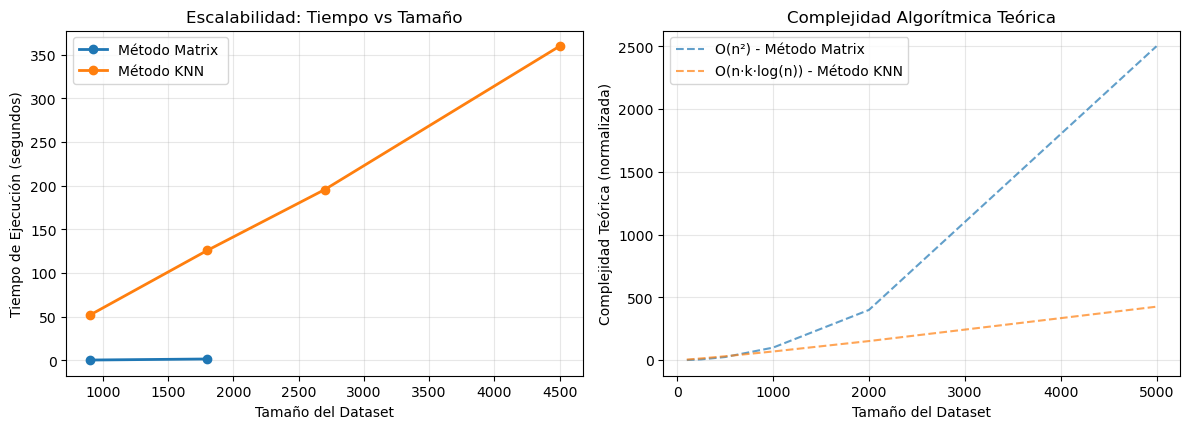

,Metodología,Partición,precision,recall,f1
0,Matriz,TRAIN,0.897016,0.311497,0.462416
1,Matriz,TEST,0.913649,0.329648,0.484490
2,KNN,TRAIN,0.945755,0.268048,0.417708
3,KNN,TEST,0.927215,0.294472,0.446987


In [13]:
def main_analysis(
    df: pd.DataFrame,
    df_test: pd.DataFrame,
    frac: float = 0.05,
    k: int = 1,
    threshold: float = 0.80,
    p_swap1: float = 0.05,
    p_swap2: float = 0.10
):
    preproc = PreprocesadorTexto()
    vec = VectorizadorTexto()
    calc = CalculadorSimilitudes(similarity_threshold=threshold)
    df_train_clean, df_test_clean = preproc.preparadorData(df, df_test)
    vectorizer = vec.preparadorVectores()
    vectorizer.fit(df_train_clean[TEXT_COL])
    train_sub = df_train_clean.sample(frac=frac, random_state=42)
    test_sub = df_test_clean.sample(frac=frac, random_state=42)
    train_noisy1 = train_sub[TEXT_COL].apply(lambda t: anadiendo_noise(t, p_swap1))
    train_noisy2 = train_sub[TEXT_COL].apply(lambda t: anadiendo_noise(t, p_swap2))
    test_noisy1 = test_sub[TEXT_COL].apply(lambda t: anadiendo_noise(t, p_swap1))
    test_noisy2 = test_sub[TEXT_COL].apply(lambda t: anadiendo_noise(t, p_swap2))
    df_true_train = pd.DataFrame(
        list(zip(
            list(train_sub[TEXT_COL]) * 2,
            train_noisy1.tolist() + train_noisy2.tolist()
        )),
        columns=["ITE_ITEM_TITLE1", "ITE_ITEM_TITLE2"]
    )
    df_true_test = pd.DataFrame(
        list(zip(
            list(test_sub[TEXT_COL]) * 2,
            test_noisy1.tolist() + test_noisy2.tolist()
        )),
        columns=["ITE_ITEM_TITLE1", "ITE_ITEM_TITLE2"]
    )
    df_comb_train = pd.DataFrame({
        TEXT_COL: pd.concat([train_sub[TEXT_COL], train_noisy1, train_noisy2], ignore_index=True)
    })
    df_comb_test = pd.DataFrame({
        TEXT_COL: pd.concat([test_sub[TEXT_COL], test_noisy1, test_noisy2], ignore_index=True)
    })
    print("\nMatriz: buscando pares TRAIN…")
    pares_train_mat = calc.preparadorParejas(df_comb_train, vectorizer)
    print(f"KNN (k={k}): buscando pares TRAIN…")
    pares_train_knn = calc.preparadorParejasKNN(df_comb_train, vectorizer, k=k)

    print("\nMatriz: buscando pares TEST…")
    pares_test_mat = calc.preparadorParejas(df_comb_test, vectorizer)
    print(f"KNN (k={k}): buscando pares TEST…")
    pares_test_knn = calc.preparadorParejasKNN(df_comb_test, vectorizer, k=k)
    rows = []
    for method, df_pred, df_true, part in [
        ("Matriz", pares_train_mat, df_true_train, "TRAIN"),
        ("Matriz", pares_test_mat, df_true_test, "TEST"),
        ("KNN", pares_train_knn, df_true_train, "TRAIN"),
        ("KNN", pares_test_knn, df_true_test, "TEST"),
    ]:
        m = evaluando_sintetico(df_pred, df_true)
        rows.append({
            "Metodología": method,
            "Partición": part,
            **m
        })
    metrics_df = pd.DataFrame(rows)
    print("\n=== Métricas comparativas ===")
    print(metrics_df.to_string(index=False))
    print("\n=== Escalabilidad (subsample) ===")
    anal_esc = AnalizadorEscalabilidad(calc, vectorizer)
    sizes = [int(len(df_comb_train) * f) for f in (0.2, 0.4, 0.6, 1.0)]
    for size in sizes:
        print(f"Analizando escalabilidad con {size} items...")
        anal_esc.analizandoEsc(df_comb_train.iloc[:size], [size])

    # Gráfico final
    sc_res = anal_esc.analizandoEsc(df_comb_train, sizes)
    plotear(sc_res)
    return {
        "metrics": metrics_df,
        "scalability": sc_res
    }
if __name__ == "__main__":
    resultados = main_analysis(df, df_test)
    display(resultados["metrics"])
